In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:55 - loss: 0.0140 - STD: 7.3004e-05 - MAE: 0.0630

 4/74 [>.............................] - ETA: 2s - loss: 0.0184 - STD: 3.6657e-04 - MAE: 0.0960  

 5/74 [=>............................] - ETA: 2s - loss: 0.0189 - STD: 4.2689e-04 - MAE: 0.0960

 6/74 [=>............................] - ETA: 3s - loss: 0.0193 - STD: 5.0685e-04 - MAE: 0.0958

 7/74 [=>............................] - ETA: 3s - loss: 0.0188 - STD: 6.0635e-04 - MAE: 0.0926

 8/74 [==>...........................] - ETA: 3s - loss: 0.0180 - STD: 7.2373e-04 - MAE: 0.0884

 9/74 [==>...........................] - ETA: 3s - loss: 0.0173 - STD: 8.4780e-04 - MAE: 0.0872

10/74 [===>..........................] - ETA: 3s - loss: 0.0170 - STD: 9.7168e-04 - MAE: 0.0886

11/74 [===>..........................] - ETA: 3s - loss: 0.0169 - STD: 0.0011 - MAE: 0.0904    

12/74 [===>..........................] - ETA: 3s - loss: 0.0166 - STD: 0.0012 - MAE: 0.0911

13/74 [====>.........................] - ETA: 3s - loss: 0.0163 - STD: 0.0013 - MAE: 0.0905

14/74 [====>.........................] - ETA: 3s - loss: 0.0160 - STD: 0.0014 - MAE: 0.0889

15/74 [=====>........................] - ETA: 3s - loss: 0.0157 - STD: 0.0015 - MAE: 0.0870

16/74 [=====>........................] - ETA: 3s - loss: 0.0155 - STD: 0.0015 - MAE: 0.0853

17/74 [=====>........................] - ETA: 3s - loss: 0.0154 - STD: 0.0016 - MAE: 0.0837

18/74 [======>.......................] - ETA: 3s - loss: 0.0153 - STD: 0.0017 - MAE: 0.0824

19/74 [======>.......................] - ETA: 3s - loss: 0.0151 - STD: 0.0017 - MAE: 0.0812

20/74 [=======>......................] - ETA: 3s - loss: 0.0150 - STD: 0.0018 - MAE: 0.0802

21/74 [=======>......................] - ETA: 3s - loss: 0.0148 - STD: 0.0019 - MAE: 0.0796

22/74 [=======>......................] - ETA: 3s - loss: 0.0147 - STD: 0.0020 - MAE: 0.0794

23/74 [========>.....................] - ETA: 3s - loss: 0.0146 - STD: 0.0022 - MAE: 0.0795

24/74 [========>.....................] - ETA: 3s - loss: 0.0145 - STD: 0.0023 - MAE: 0.0799

25/74 [=========>....................] - ETA: 3s - loss: 0.0144 - STD: 0.0024 - MAE: 0.0800

26/74 [=========>....................] - ETA: 4s - loss: 0.0144 - STD: 0.0025 - MAE: 0.0799

29/74 [==========>...................] - ETA: 3s - loss: 0.0140 - STD: 0.0030 - MAE: 0.0782

31/74 [===========>..................] - ETA: 3s - loss: 0.0138 - STD: 0.0033 - MAE: 0.0769

32/74 [===========>..................] - ETA: 3s - loss: 0.0137 - STD: 0.0035 - MAE: 0.0762

33/74 [============>.................] - ETA: 3s - loss: 0.0136 - STD: 0.0037 - MAE: 0.0757

34/74 [============>.................] - ETA: 3s - loss: 0.0135 - STD: 0.0039 - MAE: 0.0753

35/74 [=============>................] - ETA: 3s - loss: 0.0134 - STD: 0.0042 - MAE: 0.0751

36/74 [=============>................] - ETA: 2s - loss: 0.0133 - STD: 0.0044 - MAE: 0.0749

37/74 [==============>...............] - ETA: 2s - loss: 0.0132 - STD: 0.0048 - MAE: 0.0747

38/74 [==============>...............] - ETA: 2s - loss: 0.0131 - STD: 0.0051 - MAE: 0.0745

39/74 [==============>...............] - ETA: 2s - loss: 0.0130 - STD: 0.0055 - MAE: 0.0742

40/74 [===============>..............] - ETA: 2s - loss: 0.0129 - STD: 0.0059 - MAE: 0.0738

41/74 [===============>..............] - ETA: 2s - loss: 0.0128 - STD: 0.0063 - MAE: 0.0733

42/74 [================>.............] - ETA: 2s - loss: 0.0127 - STD: 0.0068 - MAE: 0.0728

43/74 [================>.............] - ETA: 2s - loss: 0.0126 - STD: 0.0074 - MAE: 0.0722

44/74 [================>.............] - ETA: 2s - loss: 0.0125 - STD: 0.0080 - MAE: 0.0717

45/74 [=================>............] - ETA: 2s - loss: 0.0124 - STD: 0.0086 - MAE: 0.0713

46/74 [=================>............] - ETA: 2s - loss: 0.0122 - STD: 0.0094 - MAE: 0.0708

47/74 [==================>...........] - ETA: 2s - loss: 0.0121 - STD: 0.0102 - MAE: 0.0704

48/74 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 0.0111 - MAE: 0.0700

49/74 [==================>...........] - ETA: 1s - loss: 0.0118 - STD: 0.0120 - MAE: 0.0695

50/74 [===================>..........] - ETA: 1s - loss: 0.0117 - STD: 0.0130 - MAE: 0.0690

51/74 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.0141 - MAE: 0.0685

52/74 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0152 - MAE: 0.0681

53/74 [====================>.........] - ETA: 1s - loss: 0.0113 - STD: 0.0163 - MAE: 0.0676

54/74 [====================>.........] - ETA: 1s - loss: 0.0112 - STD: 0.0175 - MAE: 0.0672

55/74 [=====================>........] - ETA: 1s - loss: 0.0111 - STD: 0.0188 - MAE: 0.0667

56/74 [=====================>........] - ETA: 1s - loss: 0.0109 - STD: 0.0200 - MAE: 0.0663

57/74 [======================>.......] - ETA: 1s - loss: 0.0108 - STD: 0.0212 - MAE: 0.0658

58/74 [======================>.......] - ETA: 1s - loss: 0.0107 - STD: 0.0223 - MAE: 0.0654

59/74 [======================>.......] - ETA: 1s - loss: 0.0105 - STD: 0.0234 - MAE: 0.0649

60/74 [=======================>......] - ETA: 1s - loss: 0.0104 - STD: 0.0244 - MAE: 0.0645

61/74 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 0.0254 - MAE: 0.0640

62/74 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.0264 - MAE: 0.0636

63/74 [========================>.....] - ETA: 0s - loss: 0.0101 - STD: 0.0274 - MAE: 0.0631

64/74 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.0283 - MAE: 0.0627

65/74 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0292 - MAE: 0.0623

66/74 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0300 - MAE: 0.0619

67/74 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.0309 - MAE: 0.0615

68/74 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0318 - MAE: 0.0611

69/74 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0328 - MAE: 0.0607

70/74 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0338 - MAE: 0.0603

71/74 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0347 - MAE: 0.0599

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0356 - MAE: 0.0596

73/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0364 - MAE: 0.0592

74/74 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0372 - MAE: 0.0589

74/74 [==============================] - 8s 81ms/step - loss: 0.0090 - STD: 0.0372 - MAE: 0.0589 - val_loss: 0.0028 - val_STD: 0.0714 - val_MAE: 0.0340


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0914 - MAE: 0.0339

 2/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0930 - MAE: 0.0339

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0930 - MAE: 0.0340

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0923 - MAE: 0.0341

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0925 - MAE: 0.0339

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0928 - MAE: 0.0337

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0928 - MAE: 0.0337

 8/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0936 - MAE: 0.0338

 9/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0337

10/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0337

11/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0337

12/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0337

13/74 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0338

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0338

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0337

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0337

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0337

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0337

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0337

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0337

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0337

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0337

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0337

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0337

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0337

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0337

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0337

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0337

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0337

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0337

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0337

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0337

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0337

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0337

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0337

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0336

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0336

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0336

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0336

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0336

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0336

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0336

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0336

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0336

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0336

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0336

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0335

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0335

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0335

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0335

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0335

53/74 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

54/74 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0334

55/74 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0334

56/74 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0334

57/74 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0334

58/74 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0334

59/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0333

60/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

61/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

62/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

63/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

64/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

65/74 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0333

66/74 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0333

67/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0333

68/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

69/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

70/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

71/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

72/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

73/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

74/74 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

74/74 [==============================] - 5s 70ms/step - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332 - val_loss: 0.0026 - val_STD: 0.0746 - val_MAE: 0.0335


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 2/74 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0994 - MAE: 0.0327

 3/74 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0998 - MAE: 0.0326

 4/74 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0999 - MAE: 0.0326

 5/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0326

 6/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0326

 7/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0324

 8/74 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0324

 9/74 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0324

10/74 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0323

11/74 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

12/74 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

13/74 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0323

14/74 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

15/74 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

16/74 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0323

17/74 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0323

18/74 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0323

19/74 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

20/74 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

21/74 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0322

22/74 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

23/74 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

24/74 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

25/74 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

26/74 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

27/74 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

28/74 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

29/74 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

30/74 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0321

31/74 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0321

32/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0321

33/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0321

34/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0321

36/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0321

37/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

38/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0321

39/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0320

40/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

41/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0320

42/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0320

43/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

44/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

45/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

46/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

47/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

48/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

49/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

50/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0319

51/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

52/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0318

53/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

54/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

55/74 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

56/74 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

57/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

58/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

63/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

69/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316

74/74 [==============================] - 5s 70ms/step - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316 - val_loss: 0.0024 - val_STD: 0.0762 - val_MAE: 0.0317


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0304

 2/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0307

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0307

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0308

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0306

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0306

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0307

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0307

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0307

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0307

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0307

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0306

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0306

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0306

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0306

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0306

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0306

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0306

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0307

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0307

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0307

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0307

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0307

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0308

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0308

28/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0308

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0308

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0308

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0308

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0308

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0308

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0308

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

41/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

42/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

43/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

44/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

45/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

54/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

57/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

58/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

59/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0306

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0306

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0306

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

65/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

69/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0306

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0305

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0305

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0305

74/74 [==============================] - 5s 71ms/step - loss: 0.0021 - STD: 0.0991 - MAE: 0.0305 - val_loss: 0.0023 - val_STD: 0.0770 - val_MAE: 0.0308


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0299

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0301

 3/74 [>.............................] - ETA: 5s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0299

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0299

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0300

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0301

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0304

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0305

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0305

12/74 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0305

13/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0305

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0304

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0303

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0303

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0303

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0303

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0303

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0303

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0303

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0302

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0302

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0301

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0301

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0301

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0301

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0301

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0301

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0300

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0300

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0299

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0298

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0298

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0298

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0298

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0298

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0298

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0298

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

74/74 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300 - val_loss: 0.0030 - val_STD: 0.0823 - val_MAE: 0.0392


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.1042 - MAE: 0.0352

 2/74 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0334

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0318

 4/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0319

 5/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0326

 6/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0323

 7/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0319

 8/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0320

 9/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1010 - MAE: 0.0317

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0315

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1009 - MAE: 0.0316

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1009 - MAE: 0.0314

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.1009 - MAE: 0.0313

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0313

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0311

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0310

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0310

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0308

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0308

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0307

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0306

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0305

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0305

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0304

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0304

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0303

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0303

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0302

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0302

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0301

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0301

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0300

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0300

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0300

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0299

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0299

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0299

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0299

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0298

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

44/74 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0296

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0296

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0296

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0296

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0296

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0296

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0297

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0299

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0299

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0299

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0299

74/74 [==============================] - 5s 69ms/step - loss: 0.0020 - STD: 0.0998 - MAE: 0.0299 - val_loss: 0.0023 - val_STD: 0.0809 - val_MAE: 0.0326


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0298

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0291

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0292

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0290

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0290

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0291

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0290

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0290

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0290

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0289

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0289

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0288

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0288

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0288

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0288

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0287

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0287

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0287

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0287

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0287

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0287

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0287

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0287

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0287

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0287

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289 - val_loss: 0.0022 - val_STD: 0.0817 - val_MAE: 0.0315


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0299

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0294

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0290

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0288

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0295

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0297

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0295

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0294

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0297

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0296

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0296

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0296

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0297

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0296

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0296

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0297

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0297

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0296

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0296

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0296

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0295

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0294

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0295

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0295

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0295

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0295

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0295

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0295

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0294

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0293

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0293

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0293

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0292

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0292

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0292

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0292

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291 - val_loss: 0.0025 - val_STD: 0.0746 - val_MAE: 0.0332


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0348

 2/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0326

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0313

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0976 - MAE: 0.0311

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0311

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0305

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0299

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0298

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0298

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0298

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0296

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0296

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0297

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0296

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0296

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0297

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0296

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0295

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0295

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0294

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0294

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0293

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0293

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0292

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0288

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0288

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289 - val_loss: 0.0020 - val_STD: 0.0787 - val_MAE: 0.0293


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0284

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0995 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0288

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0287

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0287

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0287

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285 - val_loss: 0.0020 - val_STD: 0.0774 - val_MAE: 0.0293


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0283

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0287

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0285

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0283

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0283

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0282

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0286

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0286

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285 - val_loss: 0.0021 - val_STD: 0.0802 - val_MAE: 0.0310


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0285

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0284

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0283

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0281

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0282

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0282

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0282

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

74/74 [==============================] - 5s 68ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284 - val_loss: 0.0021 - val_STD: 0.0767 - val_MAE: 0.0297


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0295

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0285

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0286

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0283

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0283

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282 - val_loss: 0.0019 - val_STD: 0.0783 - val_MAE: 0.0289


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.0994 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0989 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0274

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0817 - val_MAE: 0.0305


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0280

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0278

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0279

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0280

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0281

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0282

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0283

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0776 - val_MAE: 0.0290


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0280

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0277

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0275

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280 - val_loss: 0.0019 - val_STD: 0.0775 - val_MAE: 0.0285


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0972 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0269

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0270

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

 6/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276 - val_loss: 0.0019 - val_STD: 0.0801 - val_MAE: 0.0289


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0272

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0277

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0276

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0276

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279 - val_loss: 0.0019 - val_STD: 0.0775 - val_MAE: 0.0285


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.0969 - MAE: 0.0275

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.0993 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0279

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0276

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0276

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278 - val_loss: 0.0020 - val_STD: 0.0814 - val_MAE: 0.0301


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0277

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0273

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0272

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0272

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

74/74 [==============================] - 5s 69ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275 - val_loss: 0.0019 - val_STD: 0.0804 - val_MAE: 0.0287


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0272

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0275

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0277

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276 - val_loss: 0.0020 - val_STD: 0.0763 - val_MAE: 0.0291


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0977 - MAE: 0.0290

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0286

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0281

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0278

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0278

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0278

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273 - val_loss: 0.0020 - val_STD: 0.0773 - val_MAE: 0.0292


Epoch 23/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0974 - MAE: 0.0295

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0299

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0307

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0307

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0302

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0296

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0293

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0290

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0288

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0287

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0285

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0284

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276 - val_loss: 0.0018 - val_STD: 0.0801 - val_MAE: 0.0285


Epoch 24/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0268

 3/74 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1000 - MAE: 0.0265

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0267

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0810 - val_MAE: 0.0289


Epoch 25/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0267

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0268

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274 - val_loss: 0.0018 - val_STD: 0.0798 - val_MAE: 0.0281


Epoch 26/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0267

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0999 - MAE: 0.0267

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0267

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0267

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0266

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

74/74 [==============================] - 5s 68ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270 - val_loss: 0.0020 - val_STD: 0.0768 - val_MAE: 0.0289


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0979 - MAE: 0.0286

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269 - val_loss: 0.0023 - val_STD: 0.0749 - val_MAE: 0.0313


Epoch 28/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0317

 2/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0323

 3/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0336

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0329

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0315

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0311

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0314

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0313

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0307

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0307

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0309

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0305

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0307

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0310

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0307

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0310

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0312

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0309

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0314

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0314

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0313

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0316

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0314

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0314

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0312

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0311

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0311

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0310

29/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0310

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0308

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0308

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0307

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0307

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0305

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0305

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0304

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0303

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0303

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0302

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0301

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0300

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0300

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0299

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0299

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0298

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0298

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0297

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0296

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0296

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0296

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0295

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0295

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0294

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0294

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0293

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0293

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0292

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0292

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0291

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0291

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0289

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0289

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0288

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0287

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0287

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0287

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0286

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0286 - val_loss: 0.0019 - val_STD: 0.0810 - val_MAE: 0.0285


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

30/74 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0825 - val_MAE: 0.0287


Epoch 30/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0268

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - 5s 68ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0808 - val_MAE: 0.0296


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0265

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0267

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0265

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0794 - val_MAE: 0.0281


Epoch 32/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0257

 2/74 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1006 - MAE: 0.0259

 3/74 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0260

 4/74 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0271

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0270

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0271

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0276

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0275

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269 - val_loss: 0.0021 - val_STD: 0.0749 - val_MAE: 0.0293


Epoch 33/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0017 - STD: 0.0956 - MAE: 0.0288

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0280

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.0999 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1005 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0275

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0269

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0269

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0267

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0280


Epoch 34/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0261

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0265

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0267

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0266

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0266

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0265

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0265

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0265

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0265

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0264

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0264

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0264

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0264

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0264

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0264

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0263

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0262

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0263

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0771 - val_MAE: 0.0283


Epoch 35/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0997 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0274

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0271

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0785 - val_MAE: 0.0282


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0265

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0267

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0271

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0272

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0281


Epoch 37/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0258

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0259

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0258

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0258

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0261

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0262

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0262

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0262

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0816 - val_MAE: 0.0291


Epoch 38/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0257

 2/74 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1006 - MAE: 0.0264

 3/74 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0265

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0263

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0262

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

15/74 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0261

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

29/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

44/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

59/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0782 - val_MAE: 0.0280


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.0998 - MAE: 0.0259

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0259

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262 - val_loss: 0.0020 - val_STD: 0.0756 - val_MAE: 0.0293


Epoch 40/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0957 - MAE: 0.0286

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0271

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0270

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0262

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1017 - MAE: 0.0262

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0262

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0262

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0261

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0261

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0261

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0261

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0261

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0260

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

74/74 [==============================] - 5s 68ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259 - val_loss: 0.0018 - val_STD: 0.0793 - val_MAE: 0.0282


Epoch 41/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0258

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0258

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0260

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0265

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0271

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0268

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0263

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - 5s 68ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0807 - val_MAE: 0.0285


Epoch 42/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

 2/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

 3/74 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0252

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0253

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0255

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

74/74 [==============================] - 5s 70ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259 - val_loss: 0.0021 - val_STD: 0.0753 - val_MAE: 0.0302


Epoch 43/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0965 - MAE: 0.0299

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0270

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1008 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1006 - MAE: 0.0267

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0265

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0264

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0263

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0262

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261 - val_loss: 0.0019 - val_STD: 0.0773 - val_MAE: 0.0282


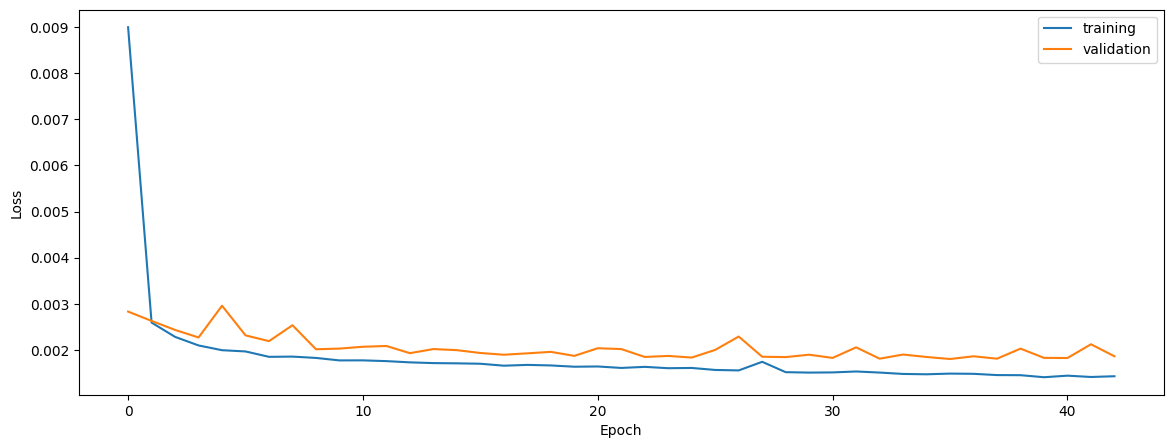

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.939390327134425
0.9358140057017346
0.9334240219269745


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.939390327134425
0.9358140057017346
0.9334240219269745


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.943161601889308
0.9397206255844452
0.9425668678893047


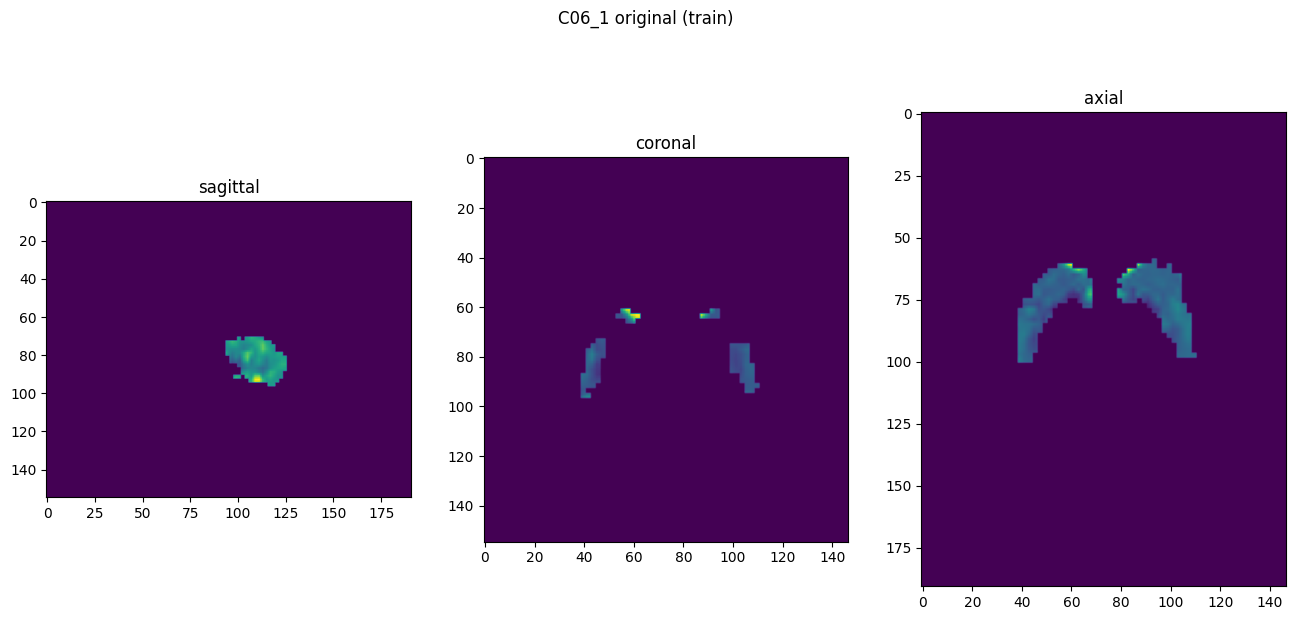

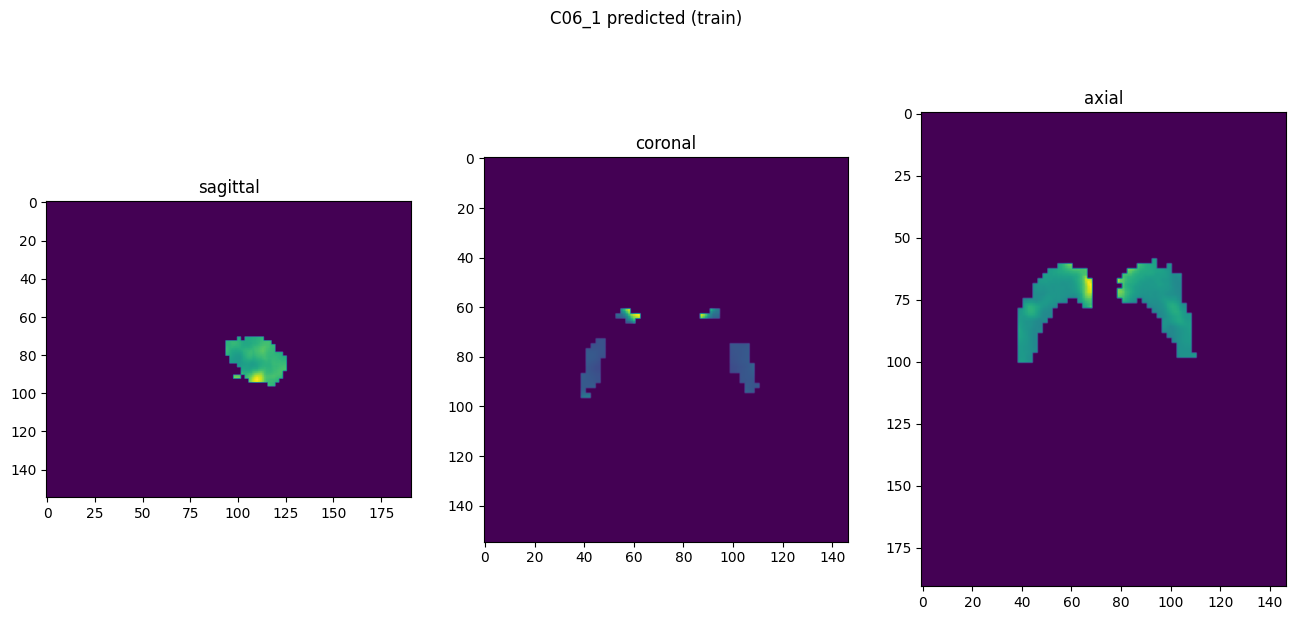

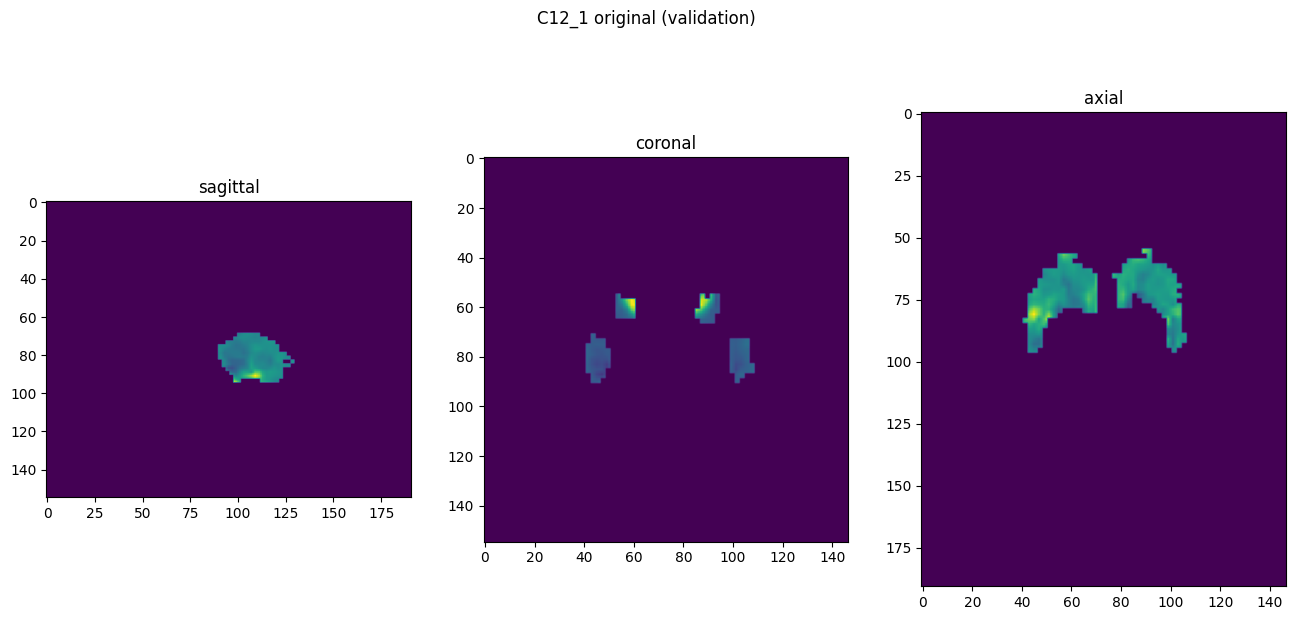

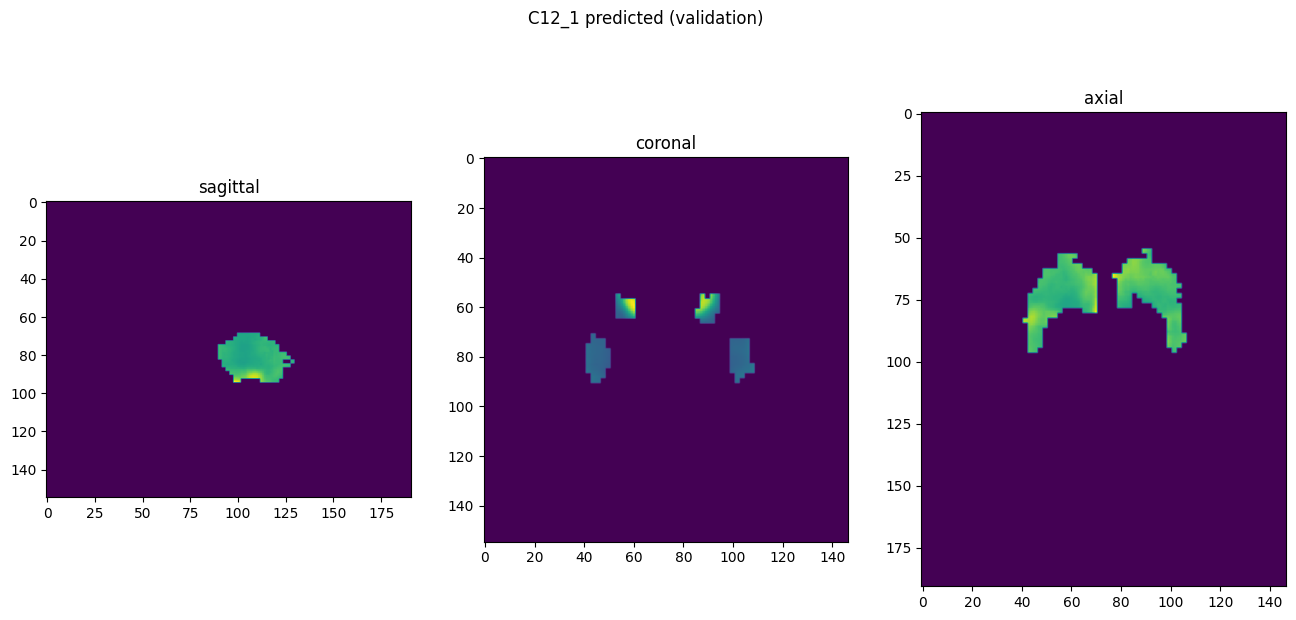

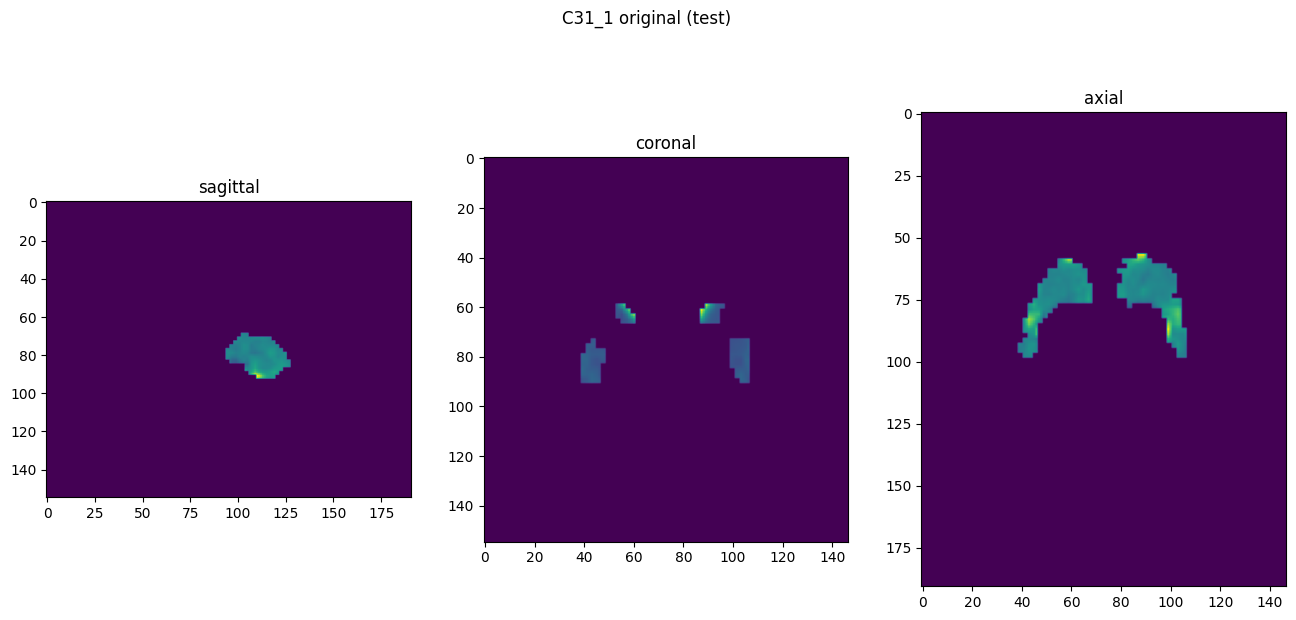

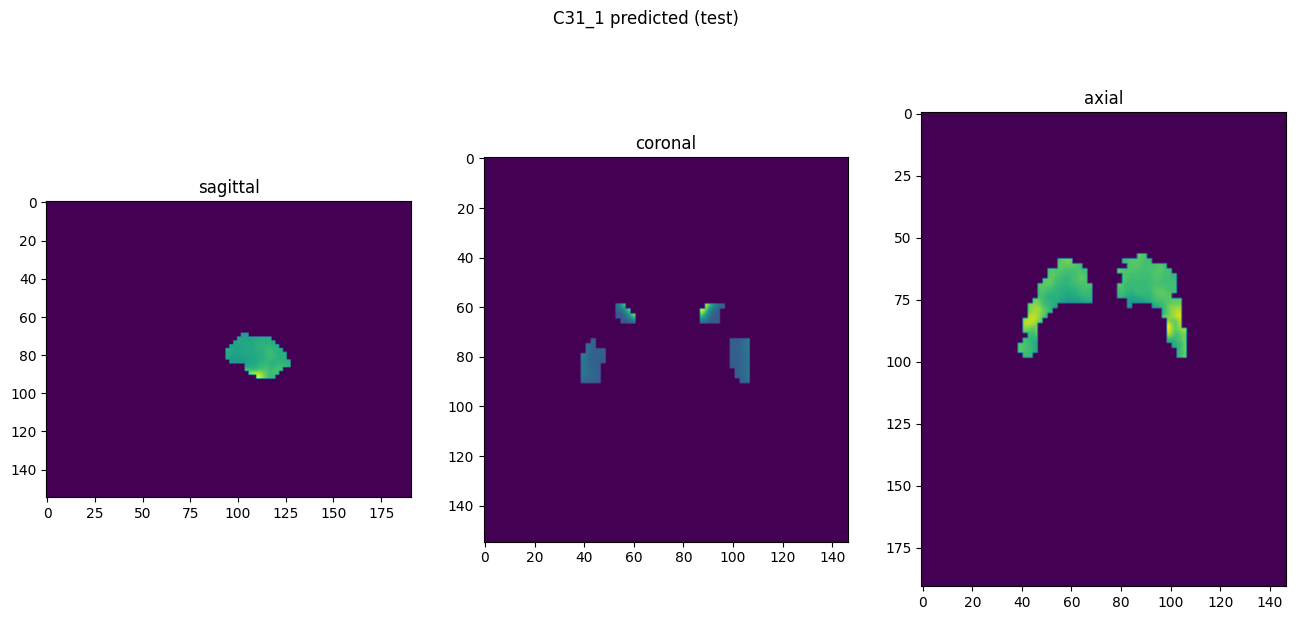

In [10]:
showResults(model, gen, threshold=None, background=False)